In [1]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline
from scipy.optimize import leastsq, least_squares
import utils
from collections import defaultdict
from LinearAlignment import LinearAlignment

In [2]:
np.random.seed(50)
coord_cols = ['x', 'y', 'z']
speed_cols = ['Vx', 'Vy', 'Vz']
state_cols = coord_cols + speed_cols
# anchor_cols = state_cols + ['distance', 'abs_speed']

In [3]:
G = 6.6743e-11 # gravity constant
M = 5.972e+24  # Earth mass

# coord = np.array([x, y, z])
# speed = np.array([Vx, Vy, Vz])
# sat_state = np.array([x, y, z, Vx, Vy, Vz])
def Earth_gravity_model(sat_state, dt):
    coord = sat_state[:3]
    speed = sat_state[3:]
    r = np.linalg.norm(coord)       # distance to satellite
    a_abs = (G * M) / (r ** 2)      # acceleration absolutevalue
    a = -(coord / r) * a_abs
    result_speed = speed + a * dt
    result_coord = coord + (speed + result_speed) / 2 * dt
    return np.concatenate([result_coord, result_speed])


# iterating Earth_gravity_model or other function with same interface
def iterative_trajectory_modelling(model, start_state, t_simulation, dt):
    current_state = start_state
    for step in range(int(t_simulation / dt)):
        current_state = model(sat_state=current_state, dt=dt)
    current_state = model(current_state, dt=t_simulation % dt)
    return current_state

# predicting past states
def inverse_iterative_trajectory_modelling(model, start_state, t_simulation, dt=1):
    start_state[3:] *= -1
    end_state = iterative_trajectory_modelling(model, start_state, t_simulation, dt)
    end_state[3:] *= -1
    return end_state


def time_state(row):
    time = row['epoch']
    state = row[state_cols].values
    return time, state
    
def predict_segment(begin_row, end_row, t_new, dt):
    pred = defaultdict(lambda: {})
    if begin_row is not None:
        current_t, current_state = begin_t, begin_state = time_state(begin_row)
        for t in t_new:
            if t >= current_t:
                current_state = iterative_trajectory_modelling(
                    Earth_gravity_model, current_state * 1000, (t - current_t) / 10 ** 9,
                    dt=dt) / 1000
                current_t = t
                pred[current_t]['forward'] = {'pred': current_state, 'sim_duration': current_t - begin_t}
    if end_row is not None:
        current_t, current_state = end_t, end_state = time_state(end_row)
        for t in t_new[::-1]:
            if t <= current_t:
                current_state = inverse_iterative_trajectory_modelling(
                    Earth_gravity_model, current_state * 1000, (current_t - t) / 10 ** 9,
                    dt=dt) / 1000
                current_t = t
                pred[current_t]['backward'] = {'pred': current_state, 'sim_duration': end_t - current_t}
                
    segment_df = []
    for t in sorted(pred.keys()):
        assert len(pred[t]) > 0
        t_pred = np.zeros(6)
        t_weights_sum = 0
        
        for simulation, simulation_res in pred[t].items():
            assert simulation_res['sim_duration'] >= 0
            weight = 1 / (simulation_res['sim_duration'] + 1)
            t_pred += simulation_res['pred'] * weight
            t_weights_sum += weight
            
        segment_df.append(np.concatenate([[t], t_pred / t_weights_sum]))
    return segment_df

def sparse_pred_to_dense(sparse_sat_data, t_new, dt):
    
    
    result = []
    first_row = sparse_sat_data.iloc[0]
    result.extend(predict_segment(None, first_row, t_new[t_new < first_row['epoch']], dt=dt))
    
#     t_new_id_min = t_new_id_max = 0
    for row_id in range(len(sparse_sat_data) - 1):
        begin_row = sparse_sat_data.iloc[row_id]
        end_row = sparse_sat_data.iloc[row_id + 1]
        segment = t_new[(t_new >= begin_row['epoch']) & (t_new < end_row['epoch'])]
        result.extend(predict_segment(begin_row, end_row, segment, dt=dt))
    result.extend(predict_segment(end_row, None, t_new[t_new >= end_row['epoch']], dt=dt))
    return pd.DataFrame(result, columns=['t',] + state_cols)
        
        

In [14]:
# basic function used in ZeroKeypointsGenerator
# finding t: x(t)=0.
def get_key_points(t, x):
    spl = InterpolatedUnivariateSpline(t, x)
    roots = spl.roots()
    key_points = roots[1::2]
    if len(key_points) < 3:
        return key_points, np.zeros_like(key_points)
    
    outlier_scores = np.abs((key_points[2:] + key_points[:-2] - 2 * key_points[1:-1]) /
                             key_points[1:-1])
    np.pad(np.abs((key_points[2:] + key_points[:-2] - 2 * key_points[1:-1]) /
                             key_points[1:-1]), (2, 2), mode = 'constant')
    
    threshold = 3 * np.percentile(outlier_scores, 75) - 2 * np.percentile(outlier_scores, 25)
    outliers = (np.convolve(np.pad(outlier_scores > threshold, (2, 2),constant_values=1, mode = 'constant'), [1, 1, 1]) == 3)[2:-2]
    return key_points, outliers

In [15]:
# a * x + b -> (x - b) / a
def inverse_to_linear(func):
    b = func(0)
    a = func(1) - b
    return lambda x: (x - b) / a

In [16]:
def linear_params(t, x):
    model_func = lambda params, t: (params[0] * t + params[1])
    a = (x[-1] - x[0]) / (t[-1] - t[0])
    b = x[0] - a * t[0]
    init_params = (a, b)
    return model_func, init_params

# sinusoid + linear
def sinusoid_plus_linear_params(t, x):
    model_func = lambda params, t: (params[0] *
                                    np.sin(params[1] * t + params[2]) +
                                    params[3] + t * params[4])
    init_params = (np.std(x), 1/(t[-1] - t[0]), 0, np.mean(x), (x[-1] - x[0]) / (t[-1] - t[0]))
    return model_func, init_params

def pick_model_function(t, x):
#     print(len(t))
    if len(t) >= 10:
        return sinusoid_plus_linear_params(t, x)
    else:
        return linear_params(t, x)

def fit_curve(t, x, model_func, init_params):
    def optimize_func(params):
        return model_func(params, t) - x

    ls_params = leastsq(optimize_func, init_params)[0]
    return lambda x: model_func(ls_params, x)

In [17]:
class ZeroKeypointsGenerator:
    def __init__(self, anchor_feature):
        self.anchor_feature = anchor_feature
    
    def get_sim_keypoints(self, sat_data):
        return get_key_points(sat_data['epoch'], sat_data[self.anchor_feature + '_sim'])
    
    def get_gt_keypoints(self, sat_data):
        return get_key_points(sat_data['epoch'], sat_data[self.anchor_feature])
    
# generating a lattice of keypoints
class ShiftZeroKeypointsGenerator:
    def __init__(self, anchor_feature, alpha=1):
        self.anchor_feature = anchor_feature
        self.alpha = alpha
    
    def get_sim_keypoints(self, sat_data):
        kp, outliers = get_key_points(sat_data['epoch'], sat_data[self.anchor_feature + '_sim'])
        outliers = outliers[1:] | outliers[:-1]
        period = kp[1:] - kp[:-1]
        return kp[:-1] + period * self.alpha, outliers
    
    def get_gt_keypoints(self, sat_data):
        kp, outliers = get_key_points(sat_data['epoch'], sat_data[self.anchor_feature])
        outliers = outliers[1:] | outliers[:-1]
        period = kp[1:] - kp[:-1]
        return kp[:-1] + period * self.alpha, outliers
    


In [18]:
def sine_alignment(sat_id, kp_generator, train_t_max):
    sat_data = utils.get_satellite_data(data, sat_id).reset_index(drop=True)
    sat_data = utils.remove_time_jumps_fast(sat_data)
    
    train_sat_data = sat_data[sat_data['epoch'] <= train_t_max]
    
    all_sim_kp, all_sim_kp_outliers = kp_generator.get_sim_keypoints(sat_data)
    # broken simulation handling
    if sat_id == 481:
        pred = sat_data[sat_data['epoch'] > train_t_max][['epoch'] + [c + '_sim' for c in state_cols]]
        pred.columns =  ['t'] + state_cols
        return pred
        
    train_gt_kp, train_gt_kp_outliers = kp_generator.get_gt_keypoints(train_sat_data)
    
    stretch_data = all_sim_kp[:len(train_gt_kp)], train_gt_kp
    if len(train_gt_kp) >= 5:
        use_kp = ~(all_sim_kp_outliers[:len(train_gt_kp)] | train_gt_kp_outliers)
        stretch_data = (stretch_data[0][use_kp], stretch_data[1][use_kp])
    time_stretch_function = fit_curve(*stretch_data,
                                      *pick_model_function(all_sim_kp[:len(train_gt_kp)], train_gt_kp))

    
    keypoints = time_stretch_function(all_sim_kp)
    train_keypoints = keypoints[keypoints < train_t_max]
    test_keypoints = keypoints[len(train_keypoints):]
    
    
    
    sim_stretched_t = time_stretch_function(sat_data['epoch'])
    train_sim_stretched_t = sim_stretched_t[:len(train_sat_data)]
    
    pred = []
    gt = []
    for feature in state_cols:
        sim_feature = feature + '_sim'

        
        # values of simulation at all key points
        all_kp_sim_feature = utils.resample(t=sim_stretched_t.values,
                                              x=sat_data[sim_feature].values,
                                              t_new=keypoints)
        # values of simulation at train key points
        train_kp_sim_feature = all_kp_sim_feature[:len(train_keypoints)]
        
        # ground truth values at train key points
        train_kp_gt_feature = utils.resample(t=train_sat_data['epoch'],
                                             x=train_sat_data[feature],
                                             t_new=train_keypoints)

        # difference between train and ground truth at train keypoints
        train_diff = train_kp_gt_feature - train_kp_sim_feature
#         kp_diff_func = lambda x: np.ones_like(x) * np.mean(train_diff)
        kp_diff_func = fit_curve(train_keypoints, train_diff,
                                  *linear_params(train_keypoints, train_diff))
        pred_kp_diff = kp_diff_func(test_keypoints)


        pred.append(pred_kp_diff + all_kp_sim_feature[len(train_keypoints):])
    pred_df = pd.DataFrame(np.array(pred), index=state_cols).T
    pred_df['epoch'] = test_keypoints
    return pred_df

In [19]:
def average_meta_prediction(predictions):
#     for sat_id, sat_predictions in sorted(predictions.keys()):
#         print(np.mean([p.values[:, 1:] for p in sat_predictions], axis=0))
    result = [np.median([p.values[:, 1:] for p in sat_predictions], axis=0)
              for sat_id, sat_predictions in sorted(predictions.items())]
    result = np.concatenate(result)
    return pd.DataFrame(result, columns=state_cols, index = test_data.index)

def pick_self_meta_prediction(predictions):
#     for sat_id, sat_predictions in sorted(predictions.keys()):
#         print(np.mean([p.values[:, 1:] for p in sat_predictions], axis=0))
    result = []
    for sat_id, sat_predictions in sorted(predictions.items()):
        sat_pred = np.zeros_like(sat_predictions[0][state_cols])
        for i, p in enumerate(sat_predictions):
            sat_pred[:, i] = p[state_cols[i]].values
        result.append(sat_pred)
    result = np.concatenate(result)
    return pd.DataFrame(result, columns=state_cols, index = test_data.index)

In [107]:
train_data = pd.read_csv('data/train.csv', index_col='id')
train_data['epoch'] = pd.to_datetime(train_data['epoch']).values.astype(float)

test_data = pd.read_csv('data/test.csv', index_col='id')
test_data['epoch'] = pd.to_datetime(test_data['epoch']).values.astype(float)

data = pd.concat([train_data, test_data], sort=False).reset_index(drop=True)

In [108]:
all_predictions_shiftzero_kp ={}
all_predictions_shiftzero_kp_train = {}

In [109]:
# This modelling takes about 10 hours on my old laptop.
for sat_id in tqdm(test_data['sat_id'].unique()):
    try:
        train_t = utils.get_satellite_data(train_data, sat_id)['epoch']
        test_t = utils.get_satellite_data(test_data, sat_id)['epoch']
        time = pd.concat([train_t, test_t])
        split_time = int(3/4*len(train_t))
        train_t = time.iloc[:split_time]
        test_t = time.iloc[split_time:]

        pred_dfs = []
        sparse_pred_dfs = []
        # running sine_alignment for different lattices:
        # different alphas and anchor features
        for anchor in state_cols:
            for alpha in np.linspace(0, 1, 100)[1:]:
                pred_df = sine_alignment(sat_id, ShiftZeroKeypointsGenerator(anchor, alpha), train_t.max())
                sparse_pred_dfs.append(pred_df)
        sparse_pred = pd.concat(sparse_pred_dfs).sort_values('epoch').reset_index(drop=True)
        dense_pred = sparse_pred_to_dense(sparse_pred, test_t, dt=8)
        dense_pred.index = test_t.index
        dense_pred['sat_id'] = sat_id
        all_predictions_shiftzero_kp[sat_id] = dense_pred
        
#         dense_pred_train = sparse_pred_to_dense(sparse_pred, train_t, dt=8)
#         all_predictions_shiftzero_kp_train[sat_id] = dense_pred_train
        #backup save
        with open(f'data/tmp{sat_id}.pkl', 'wb') as f:
            pkl.dump(dense_pred, f)
    except Exception as e:
        print(e)











  0%|                                                                                          | 0/300 [00:00<?, ?it/s]C:\Users\Tatiana\Anaconda3\envs\idao\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)








  0%|▎                                                                             | 1/300 [03:01<15:02:58, 181.20s/it]







  1%|▌                                                                             | 2/300 [03:55<11:50:37, 143.08s/it]







  1%|▊                                                                              | 3/300 [04:41<9:23:43, 113.88s/it]







  1%|█                                                                              | 4/300 [06:36<9:23:28, 114.22s/it]







 20%|███████████████▋                                                             | 61/300 [1:36:27<5:31:07, 83.13s/it]







 21%|███████████████▉                                                             | 62/300 [1:36:56<4:25:13, 66.86s/it]







 21%|████████████████▏                                                            | 63/300 [1:38:40<5:08:17, 78.05s/it]







 21%|████████████████▍                                                            | 64/300 [1:41:06<6:26:40, 98.31s/it]







 22%|████████████████▍                                                           | 65/300 [1:44:12<8:08:12, 124.65s/it]







 22%|████████████████▋                                                           | 66/300 [1:45:57<7:43:31, 118.85s/it]







 22%|████████████████▉                                                           | 67/300 [1:47:13<6:51:25, 105.95s/it]







 23%|█████████████████▏                                                          | 68/300 [1:50:19<8:22:49, 130

 42%|███████████████████████████████▋                                            | 125/300 [3:32:41<3:36:10, 74.11s/it]







 42%|███████████████████████████████▉                                            | 126/300 [3:34:00<3:39:26, 75.67s/it]







 42%|███████████████████████████████▊                                           | 127/300 [3:36:52<5:01:09, 104.45s/it]







 43%|████████████████████████████████▍                                           | 128/300 [3:38:11<4:37:48, 96.91s/it]







 43%|████████████████████████████████▋                                           | 129/300 [3:39:39<4:28:44, 94.29s/it]







 43%|████████████████████████████████▉                                           | 130/300 [3:41:22<4:33:55, 96.68s/it]







 44%|████████████████████████████████▊                                          | 131/300 [3:43:58<5:23:09, 114.73s/it]







 44%|█████████████████████████████████                                          | 132/300 [3:45:24<4:56:26, 105

 62%|██████████████████████████████████████████████▊                            | 187/300 [5:29:22<3:27:35, 110.23s/it]







 63%|███████████████████████████████████████████████                            | 188/300 [5:30:48<3:11:46, 102.74s/it]







 63%|███████████████████████████████████████████████▎                           | 189/300 [5:32:26<3:07:33, 101.38s/it]







 63%|███████████████████████████████████████████████▌                           | 190/300 [5:36:54<4:37:35, 151.41s/it]







 64%|███████████████████████████████████████████████▊                           | 191/300 [5:38:12<3:55:02, 129.38s/it]







 64%|████████████████████████████████████████████████                           | 192/300 [5:40:17<3:50:29, 128.05s/it]







 64%|████████████████████████████████████████████████▉                           | 193/300 [5:40:40<2:52:02, 96.47s/it]







 65%|████████████████████████████████████████████████▍                          | 194/300 [5:43:12<3:19:58, 113

'epoch'










 82%|█████████████████████████████████████████████████████████████▎             | 245/300 [7:31:20<1:58:25, 129.19s/it]







 82%|█████████████████████████████████████████████████████████████▍             | 246/300 [7:32:56<1:47:24, 119.34s/it]







 82%|█████████████████████████████████████████████████████████████▊             | 247/300 [7:33:57<1:29:45, 101.61s/it]







 83%|██████████████████████████████████████████████████████████████             | 248/300 [7:37:01<1:49:31, 126.38s/it]







 83%|██████████████████████████████████████████████████████████████▎            | 249/300 [7:38:51<1:43:15, 121.48s/it]







 83%|██████████████████████████████████████████████████████████████▌            | 250/300 [7:46:22<3:03:41, 220.43s/it]







 84%|██████████████████████████████████████████████████████████████▊            | 251/300 [7:50:11<3:02:09, 223.06s/it]







 84%|███████████████████████████████████████████████████████████████            | 252/300 [7:52:43<2:41

In [110]:
transformed = pd.concat([all_predictions_shiftzero_kp[k]
                            for k in sorted(all_predictions_shiftzero_kp.keys())])

In [111]:
transformed.tail()

,t,x,y,z,Vx,Vy,Vz,sat_id
id,,,,,,,,
1231060,1.393565e+18,77016.322387,-59815.374927,-594.557653,-0.799028,-1.293309,0.162352,597
1231061,1.393572e+18,70266.398556,-68614.976645,603.457189,-1.029590,-1.092367,0.162347,597
1231062,1.393579e+18,61911.528690,-75847.910872,1787.734127,-1.235166,-0.867674,0.158627,597
1231063,1.393587e+18,52130.919473,-81332.770583,2930.727783,-1.416777,-0.617201,0.151099,597
1231064,1.393594e+18,41102.938911,-84867.203268,4003.243137,-1.573571,-0.337276,0.139404,597


In [112]:
data = pd.concat([train_data, test_data], sort=False)
for feat in state_cols:
    data.loc[transformed.index, f'{feat}_sim'] = transformed.loc[:, feat]
print(data.shape)
data.tail()

(933983, 14)


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
1231060,1.393565e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,77016.322387,-59815.374927,-594.557653,-0.799028,-1.293309,0.162352
1231061,1.393572e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,70266.398556,-68614.976645,603.457189,-1.029590,-1.092367,0.162347
1231062,1.393579e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,61911.528690,-75847.910872,1787.734127,-1.235166,-0.867674,0.158627
1231063,1.393587e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,52130.919473,-81332.770583,2930.727783,-1.416777,-0.617201,0.151099
1231064,1.393594e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,41102.938911,-84867.203268,4003.243137,-1.573571,-0.337276,0.139404


In [113]:
data = data.loc[transformed.index, :]
print(data.shape)

(362675, 14)


In [115]:
data.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
1231060,1.393565e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,77016.322387,-59815.374927,-594.557653,-0.799028,-1.293309,0.162352
1231061,1.393572e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,70266.398556,-68614.976645,603.457189,-1.029590,-1.092367,0.162347
1231062,1.393579e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,61911.528690,-75847.910872,1787.734127,-1.235166,-0.867674,0.158627
1231063,1.393587e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,52130.919473,-81332.770583,2930.727783,-1.416777,-0.617201,0.151099
1231064,1.393594e+18,597,NaN,NaN,NaN,NaN,NaN,NaN,41102.938911,-84867.203268,4003.243137,-1.573571,-0.337276,0.139404


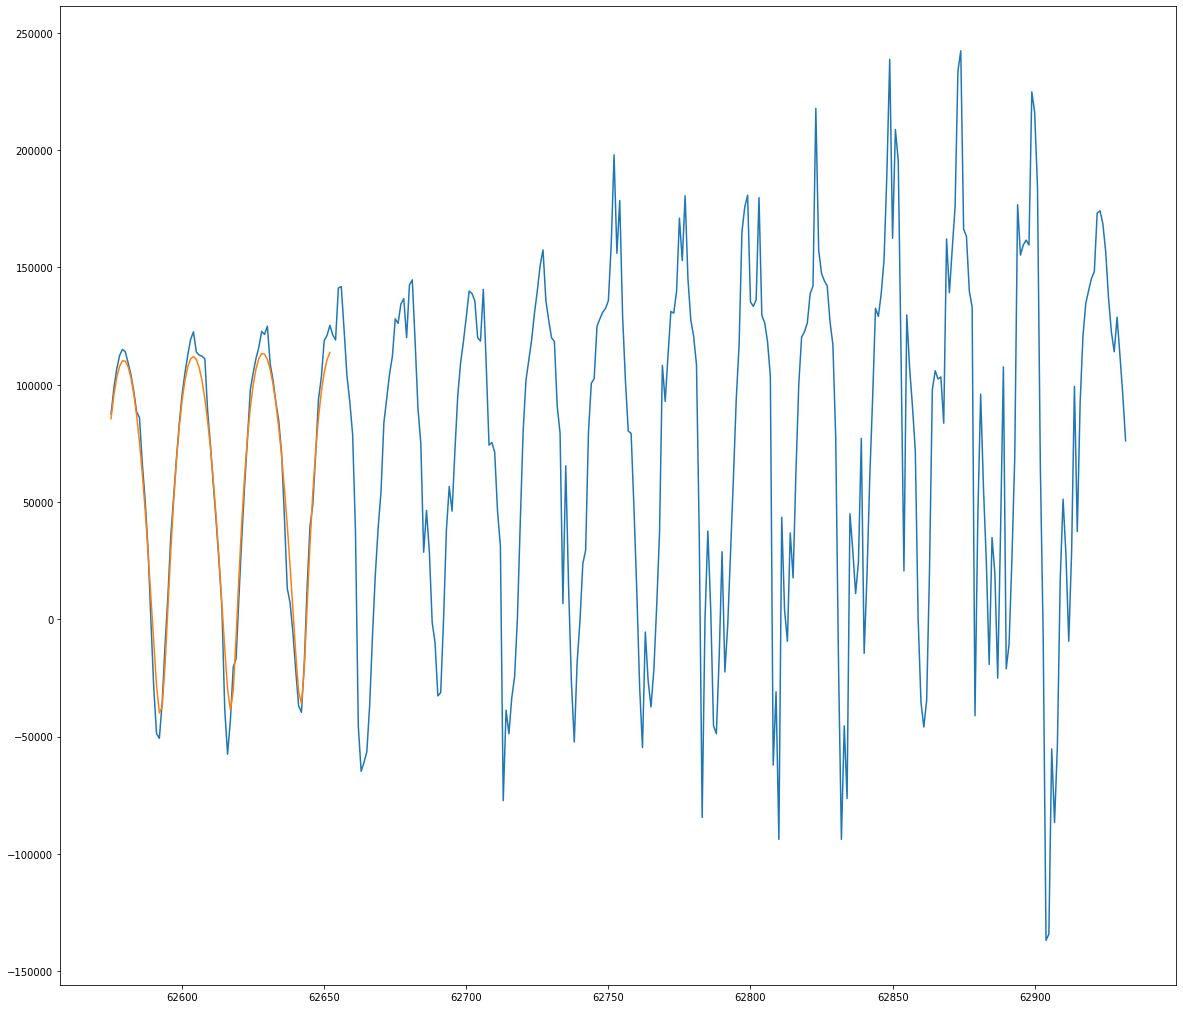

In [157]:
plt.figure(figsize = (20,18))

plt.plot(data[data.sat_id==35]['y_sim'])
plt.plot(data[data.sat_id==35]['y'])
# plt.plot(res[res.sat_id==34]['y'])
# plt.xlim([61300,61400])

In [82]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [142]:
# data[data.sat_id == 481]

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,


In [163]:
# data.to_csv('transformed_data.csv')

In [166]:
data = pd.read_csv('transformed_data.csv')
data.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3400,1.390544e+18,1,-16092.302493,-13275.413883,7590.794788,4.006022,-0.632871,0.755590,-15968.168631,-13270.526776,7476.190362,4.060799,-0.675317,0.756349
1,3401,1.390545e+18,1,-10514.368549,-13620.712878,8282.998531,4.769115,0.152157,0.291364,-10496.083783,-13639.341658,8146.091533,4.843105,0.083388,0.303908
2,3402,1.390546e+18,1,-3986.926577,-12670.717346,8183.491284,5.458695,1.457726,-0.528862,-3145.280631,-13191.900341,8233.661369,6.138835,1.558699,-0.598268
3,3403,1.390548e+18,1,3100.751237,-9519.306227,6650.863355,5.455100,3.683694,-2.025330,4435.593634,-9254.477851,6315.682653,5.560928,4.483516,-2.501181
4,3404,1.390549e+18,1,8687.726999,-3020.484451,2743.930491,2.619850,6.381215,-4.073094,8755.212612,-2677.589919,2512.017527,2.467354,6.488102,-4.129147


In [164]:
fail_list = []

satellites_list = data['sat_id'].unique()
res = pd.DataFrame([])
for sat_id in tqdm(satellites_list[100:]):
    np.random.seed(50)  
    
    
    sat_data = data[data.sat_id == sat_id]
    sat_data['t'] = ((pd.to_datetime(sat_data['epoch']) - pd.to_datetime(sat_data['epoch']).iloc[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    
    n_train = len(sat_data[~pd.isna(sat_data.x)])
#     n_first = len(sat_data[~pd.isna(sat_data.x)])

    pred = pd.DataFrame(index = sat_data.iloc[n_train:].index)
    pred['epoch'] = sat_data['epoch'].iloc[n_train:].values
    pred['t'] = sat_data['t'].iloc[n_train:].values
    pred['sat_id'] = sat_id

    
    try:

        for feature_name in state_cols:

            q = InterpolatedUnivariateSpline(sat_data['t'][:n_train], sat_data[f'{feature_name}_sim'][:n_train]).roots()
            T = (q[2]-q[0])

            # create a DataFrame for prophet model()
            ts = pd.DataFrame([])
            ts['ds'] = pd.to_datetime(sat_data ['epoch']).values
            ts['y'] = sat_data [feature_name].values-sat_data [f'{feature_name}_sim'].values

            
            # define the time frame for the first forecast 
            future =ts[n_train:] [['ds']]

            # define the model
            m = Prophet(changepoint_prior_scale = T/20,
            weekly_seasonality = False,
            yearly_seasonality = False).add_seasonality(name='grid', period = T, fourier_order=50)

            #fit the model and make the forecast
            m.fit(ts[:n_train])
            forecast = m.predict(future)

            pred[feature_name]  = sat_data.loc[:,f'{feature_name}_sim'].iloc[n_train:].values+forecast.loc[:, 'yhat'].values





    except Exception as e:
        print(f'phophet failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

#     sat_sim_smape = utils.smape(sat_data.loc[n_train:, [f'{f}_sim' for f in features_list]].values,
#                                 sat_data.loc[n_train:, features_list].values)
#     sat_new_smape = utils.smape(pred.loc[n_train:, features_list].values,
#                                 sat_data.loc[n_train:, features_list].values)
#     result_df.append([sat_id, sat_sim_smape, sat_new_smape])
    res = res.append(pred, sort=False)











  0%|                                                                                          | 0/281 [00:00<?, ?it/s]C:\Users\Tatiana\Anaconda3\envs\idao\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()










  0%|▎                                                                               | 1/281 [01:31<7:08:35, 91.84s/it]









  1%|▌                                                                               | 2/281 [02:45<6:42:03, 86.47s/it]









  1%|▊                                                                               | 3/281 [03:34<5:47:50, 75.07s/it]









  1%|█▏                                         

KeyboardInterrupt: 

In [165]:
res.to_csv('temp.csv')

In [147]:
res.tail()

,epoch,t,sat_id,x,y,z,Vx,Vy,Vz
id,,,,,,,,,
62337,1.393620e+18,35.619383,34,13146.502967,-26677.313395,-4277.040215,-2.046287,-1.514106,-2.801104
62338,1.393622e+18,35.648178,34,7903.027329,-29280.713888,-11004.760693,-2.383649,-0.649017,-2.556845
62339,1.393625e+18,35.676973,34,1589.721219,-29880.148934,-16984.668358,-2.519449,0.167751,-2.164568
62340,1.393627e+18,35.705768,34,-3351.560398,-29096.322026,-21652.907272,-2.506922,0.679003,-1.831139
62341,1.393630e+18,35.734563,34,-11063.052043,-25584.524261,-25665.940554,-2.325158,1.367568,-1.232719


In [162]:
utils.smape(data[data.sat_id ==32]['x'][:n_train],data[data.sat_id ==32]['x_sim'][:n_train])

0.004455594603309895

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t
id,,,,,,,,,,,,,,,
62575,1.390546e+18,35,-4772.884184,85506.028059,42833.704707,0.394513,1.336840,-1.106186,-5486.621381,87439.697645,43862.135421,0.414047,1.396256,-1.124676,0.000000
62576,1.390554e+18,35,-1317.915345,95635.675437,32657.118654,0.403605,1.012874,-1.241854,-2059.084886,98544.947204,33041.476529,0.409759,1.013921,-1.232315,0.099908
62577,1.390563e+18,35,2159.521289,103038.054053,21542.225038,0.400308,0.704718,-1.325859,1237.014382,106611.498635,22319.985612,0.402057,0.714008,-1.288111,0.199816
62578,1.390572e+18,35,5565.490617,107842.052817,9884.182285,0.387396,0.410464,-1.369112,4664.440487,112415.259591,11324.245558,0.399056,0.463485,-1.335210,0.299724
62579,1.390580e+18,35,8824.612443,110157.497406,-1996.542484,0.366481,0.127728,-1.378297,8173.942605,115014.209048,-566.621498,0.387149,0.209023,-1.357533,0.399633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62928,1.393593e+18,35,NaN,NaN,NaN,NaN,NaN,NaN,37337.444066,114051.342698,-123216.803768,-0.327750,-1.028729,0.256014,35.267573
62929,1.393601e+18,35,NaN,NaN,NaN,NaN,NaN,NaN,52338.496481,128786.683543,-156913.124357,-0.210187,-2.019069,-0.525308,35.367481
62930,1.393610e+18,35,NaN,NaN,NaN,NaN,NaN,NaN,51091.575604,112670.772052,-161811.192236,-0.323475,-2.119497,-0.125708,35.467390


In [144]:
# satellite 481 has broken simulation.
all_predictions_shiftzero_kp[481] = sine_alignment(481, ShiftZeroKeypointsGenerator('x', 0), train_t.max())

IndexError: index out of bounds

In [ ]:
df_shiftzero_kp = pd.concat([all_predictions_shiftzero_kp[k]
                            for k in sorted(all_predictions_shiftzero_kp.keys())])[state_cols]
df_shiftzero_kp.index = test_data.index
# saving submission csv
df_shiftzero_kp.to_csv('data/Track 1/submissions/sine_alignment/shiftzero_kp.csv', index_label='id')

In [ ]:
for sat_id in tqdm(test_data['sat_id'].unique()[:10]):
    try:
        train_t = utils.get_satellite_data(train_data, sat_id)['epoch']
        test_t = utils.get_satellite_data(test_data, sat_id)['epoch']
        pred_dfs = []
        sparse_pred_dfs = []
        # running sine_alignment for different lattices:
        # different alphas and anchor features
        for anchor in state_cols:
            for alpha in np.linspace(0, 1, 100)[1:]:
                pred_df = sine_alignment(sat_id, ShiftZeroKeypointsGenerator(anchor, alpha), train_t.max()*3/4)
                sparse_pred_dfs.append(pred_df)
        sparse_pred = pd.concat(sparse_pred_dfs).sort_values('epoch').reset_index(drop=True)
        dense_pred_test = sparse_pred_to_dense(sparse_pred, test_t, dt=8)
        all_predictions_shiftzero_kp[sat_id] = dense_pred_test
        
        dense_pred_train = sparse_pred_to_dense(sparse_pred, train_t[3/4*len(t_train):], dt=8)
        all_predictions_shiftzero_kp_train[sat_id] = dense_pred_train
        #backup save
        with open(f'data/tmp{sat_id}.pkl', 'wb') as f:
            pkl.dump(dense_pred, f)
    except Exception as e:
        print(e)

